In [7]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
folder = "kaggle-cardio/"
cardio_file = "cardio_train.csv"

df_cardio = pd.read_csv(f"{folder}{cardio_file}", sep = ";")

df_cardio["bmi"] = df_cardio["weight"] / (df_cardio["height"] / 100) ** 2

def plot_column(df, col_name, min, max):
    return df[(df[col_name] > min) & (df[col_name] < max)]

df_cardio = plot_column(df_cardio, "bmi", min = 15, max = 50)

df_cardio["bmi_category"] = pd.cut(
    df_cardio["bmi"], 
    bins = [0, 25, 30, 35, 40, 1000], 
    labels = ["Normal", "Overweight", "Obese (Class I)", "Obese (Class II)", "Obese (Class III)"], 
    right = False
)

df_cardio = plot_column(df_cardio, "ap_hi", min = 75, max = 200)

df_cardio = plot_column(df_cardio, "ap_lo", min = 50, max = 150)

In [8]:
def ap_categorizer(hi, lo):
    '''ap_categorizer() takes blood two pressure values as arguments and returns the blood pressure category'''

    if hi >= 180 or lo >= 120: return "Hypertension crisis"
    if hi >= 140 or lo >= 90: return "Stage 2 hypertension"
    if hi < 120 and lo < 80: return "Healthy"
    if hi < 130 and lo < 80: return "Elevated"
    return "Stage 1 hypertension"

df_cardio["ap_category"] = df_cardio.apply(lambda x: ap_categorizer(x["ap_hi"], x["ap_lo"]), axis = 1).astype("category")

In [9]:
df_cardio_first = df_cardio.drop(["ap_hi", "ap_lo", "height", "weight", "bmi"], axis = 1)
df_cardio_first = pd.get_dummies(df_cardio_first, columns = ["bmi_category", "ap_category", "gender"], drop_first = True)

df_cardio_second = df_cardio.drop(["bmi_category", "ap_category", "height", "weight"], axis = 1)
df_cardio_second = pd.get_dummies(df_cardio_second, columns = ["gender"], drop_first = True)

df_cardio_second.head()

,id,age,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,gender_2
0,0,18393,110,80,1,1,0,0,1,0,21.967120,1
1,1,20228,140,90,3,1,0,0,1,1,34.927679,0
2,2,18857,130,70,3,1,0,0,0,1,23.507805,0
3,3,17623,150,100,1,1,0,0,1,1,28.710479,1
4,4,17474,100,60,1,1,0,0,0,0,23.011177,0


In [10]:
def tvt_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.5, random_state = 42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

    return X_train, X_val, X_test, y_train, y_val, y_test

datasets = {}

X_train, X_val, X_test, y_train, y_val, y_test = tvt_split(df_cardio_first.drop(["id", "cardio"], axis = 1), df_cardio_first["cardio"])

X_train, X_val, X_test, y_train, y_val, y_test = tvt_split(df_cardio_second.drop(["id", "cardio"], axis = 1), df_cardio_second["cardio"])

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((34130, 10), (17065, 10), (17065, 10), (34130,), (17065,), (17065,))

In [11]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

In [12]:
#from evolutionary_algos import EvoMLPClassifier
#classifier = EvoMLPClassifier(n = 48, hidden_layers = [8], activation = "relu", random_state = 42)
#classifier.fit(scaled_X_train, y_train, epochs = 1000, verbose = 1)

In [295]:
class EvoMLPClassifier:
    '''LATEST VERSION, TESTED WITH MULTICLASS AND BINARY'''

    def __init__(self, n = 24, hidden_layers = False, activation = "relu", lr_target = 0.04, lr_initial_decay = 60, lr_final_decay = 0.03, random_state = None):

        self.n = int(round(n / 8) * 8)
        self.validation_loss_history = []
        self.training_loss_history = []
        self.random_state = random_state
        self.activation = activation
        self.lr_target = lr_target
        self.lr_initial_decay = lr_initial_decay
        self.lr_final_decay = lr_final_decay

        
        if hidden_layers:
            self.hidden_layers = hidden_layers
        else:
            self.hidden_layers = False

        

    def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0):

        n = self.n
        ndiv4 = n // 4

        if self.random_state != None:
            np.random.seed(self.random_state)

        X_train = np.c_[np.ones(X_train.shape[0]), X_train]
        y_train = y_train.astype("int8")

        if len(y_train.shape) == 1:
            self.multiclass = False
        elif len(y_train.shape) == 2 and y_train.shape[1] == 1:
            self.multiclass = False
            y_train = y_train.ravel()
        else:
            self.multiclass = True
            

        if validation_data:
            X_val, y_val = validation_data

        if self.activation == "sigmoid":
            activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif self.activation == "leaky_relu":
            activation_function = lambda x: np.maximum(0.1 * x, x)
        else:
            activation_function = lambda x: np.maximum(0, x)

        if self.multiclass == True:
            output_activation_function = lambda x: np.exp(x) / np.sum(np.exp(x), axis = 2, keepdims = True)
            
            def loss_function(y_train, y_preds):
                return np.mean(np.sum(-y_train * np.log10(y_preds), axis = 2), axis = 1)

        elif self.multiclass == False:
            output_activation_function = lambda x: (1 / (1 + np.exp(-x))).reshape(x.shape[:2])

            def loss_function(y_train, y_preds):
                return np.mean(np.abs(y_preds - y_train), axis = 1)

        lr_target = self.lr_target
        lr_initial_decay = self.lr_initial_decay
        lr_final_decay = self.lr_final_decay

        layers = [X_train.shape[1]]

        if self.hidden_layers:
            layers = [X_train.shape[1]] + self.hidden_layers

        if self.multiclass == True:
            layers = layers + [y_train.shape[1]]
        elif self.multiclass == False:
            layers = layers + [1]

        number_of_layers_minus_one = len(layers) - 1
        
        if self.multiclass == True:
            y_preds = np.zeros((n, y_train.shape[0], y_train.shape[1]))
            #y_preds = np.zeros((n, 1000, y_train.shape[1]))
        elif self.multiclass == False:
            y_preds = np.zeros((n, y_train.shape[0]))
            #y_preds = np.zeros((n, 1000))

        nets_loss = np.zeros(n)
        sorted_indices = np.arange(-(ndiv4), n, 1)
        sorted_indices = np.arange(0, n, 1)

        best_net_index = -1

        weights = []

        for i in range(number_of_layers_minus_one):
            weights += [np.random.normal(0, 1, (n, layers[i], layers[i + 1]))]

        for epoch in range(epochs):
            sample_indices = np.arange(0, X_train.shape[0])
            np.random.shuffle(sample_indices)

            while len(sample_indices) > 0:
                forward_pass = X_train[sample_indices[:1000]].T
                y_train_sampled = y_train[sample_indices[:1000]]

                
                for j in range(number_of_layers_minus_one - 1):
                    forward_pass = activation_function(weights[j].transpose(0, 2, 1) @ forward_pass)
                
                forward_pass = weights[-1].transpose(0, 2, 1) @ forward_pass

                #print(y_preds[sorted_indices[ndiv4:], sample_indices[:1000]].shape)
                
                y_preds[:, sample_indices[:1000]] = output_activation_function(forward_pass.transpose(0, 2, 1))

                nets_loss = loss_function(y_train_sampled, y_preds[:, sample_indices[:1000]])

                sorted_indices = np.argsort(nets_loss)
                mutation_sigma = math.exp(-epoch / (epochs / (lr_initial_decay * math.log10(epochs + 1)))) + lr_final_decay * math.exp(-(epoch + 1) * (1 / (epochs))) + lr_target + (-0.036 * 10 * lr_final_decay)

                for j in range(number_of_layers_minus_one):
                    weights[j][sorted_indices[0 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                    weights[j][sorted_indices[1 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                    weights[j][sorted_indices[2 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                    weights[j][sorted_indices[3 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                    weights[j][sorted_indices[4 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                    weights[j][sorted_indices[5 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))

                if best_net_index != sorted_indices[0]:
                    best_net_index = sorted_indices[0]
                    self.training_loss_history += [nets_loss[best_net_index]]
                    

                    self.best_net_weights = []
                    for j in range(number_of_layers_minus_one):
                        self.best_net_weights += [weights[j][best_net_index]]
                    
                    if validation_data:
                        self.validation_loss_history += [np.mean(np.abs(y_val - self.predict(X_val)))]
                        if verbose == 1:
                            print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - val_loss: {self.validation_loss_history[-1]}")
                    else:
                        if verbose == 1:
                            pass
                            print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - {mutation_sigma}")

                sample_indices = sample_indices[1000:]


    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]

        if self.activation == "sigmoid":
            activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif self.activation == "leaky_relu":
            activation_function = lambda x: np.maximum(0.1 * x, x)
        else:
            activation_function = lambda x: np.maximum(0, x)

        if self.multiclass == True:
            output_activation_function = lambda x: np.exp(x) / np.sum(np.exp(x), axis = 1, keepdims = True)

        elif self.multiclass == False:
            output_activation_function = lambda x: (1 / (1 + np.exp(-x))).reshape(x.shape[:1])

        forward_pass = X.T

        for j in range(len(self.best_net_weights) - 1):
            forward_pass = activation_function(self.best_net_weights[j].T @ forward_pass)
            
        forward_pass = self.best_net_weights[-1].T @ forward_pass
            
        return output_activation_function(forward_pass.T)

In [293]:
classifier = EvoMLPClassifier(n = 48, hidden_layers = [8], activation = "relu", random_state = 42)
classifier.fit(scaled_X_train, y_train, epochs = 1000, validation_data = (scaled_X_val, y_val), verbose = 1)

Epoch 0 - loss: 0.37918163750230066 - val_loss: 0.38968283210568444
Epoch 0 - loss: 0.3519839442170109 - val_loss: 0.3501530197326706
Epoch 0 - loss: 0.33279584255532146 - val_loss: 0.3324322576935052
Epoch 0 - loss: 0.2922150658986911 - val_loss: 0.30791141544493716
Epoch 0 - loss: 0.28645695804593657 - val_loss: 0.30765297120692775
Epoch 0 - loss: 0.2996603578308702 - val_loss: 0.2981230259940363
Epoch 0 - loss: 0.30514945433121515 - val_loss: 0.31276338226139117
Epoch 0 - loss: 0.2930353101765562 - val_loss: 0.2923143775670306
Epoch 0 - loss: 0.281672150383948 - val_loss: 0.29700094365034746
Epoch 0 - loss: 0.30003666584323574 - val_loss: 0.29388858936023643
Epoch 0 - loss: 0.29964267816099965 - val_loss: 0.28625551335222443
Epoch 0 - loss: 0.2674351881316396 - val_loss: 0.2900736682557648
Epoch 0 - loss: 0.2745440291181876 - val_loss: 0.2968510658322562
Epoch 0 - loss: 0.2781774025163572 - val_loss: 0.28807678873297016
Epoch 0 - loss: 0.2685763619150532 - val_loss: 0.28625551335222

/var/folders/xz/f2gwbn5n3vs4pz044n49z3cw0000gn/T/ipykernel_89777/1840960108.py:60: RuntimeWarning: overflow encountered in exp
  output_activation_function = lambda x: (1 / (1 + np.exp(-x))).reshape(x.shape[:2])


Epoch 1 - loss: 0.28268308034656303 - val_loss: 0.27379052706488216
Epoch 1 - loss: 0.2672524983210719 - val_loss: 0.27261064662707785
Epoch 1 - loss: 0.24481621414556 - val_loss: 0.2730890514293234
Epoch 1 - loss: 0.2574780710812591 - val_loss: 0.27423161045944017
Epoch 1 - loss: 0.1919595432991132 - val_loss: 0.2741576625140119
Epoch 2 - loss: 0.2645567263767943 - val_loss: 0.2754563013381908
Epoch 2 - loss: 0.26404371617590333 - val_loss: 0.2737883509436602
Epoch 2 - loss: 0.2564201309139382 - val_loss: 0.2723609448278085
Epoch 2 - loss: 0.2525211945037178 - val_loss: 0.2741773205656172
Epoch 2 - loss: 0.24425699434262196 - val_loss: 0.2752825145093881
Epoch 2 - loss: 0.2722379680505043 - val_loss: 0.2767985250575517
Epoch 2 - loss: 0.26310924417022435 - val_loss: 0.27832354503703155
Epoch 2 - loss: 0.283278396522973 - val_loss: 0.2774794108317614
Epoch 2 - loss: 0.2533283505996998 - val_loss: 0.27411619545175475
Epoch 2 - loss: 0.2819624422449374 - val_loss: 0.2757673719720599
Epoc

KeyboardInterrupt: 

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      8683
           1       0.73      0.71      0.72      8382

    accuracy                           0.73     17065
   macro avg       0.73      0.73      0.73     17065
weighted avg       0.73      0.73      0.73     17065



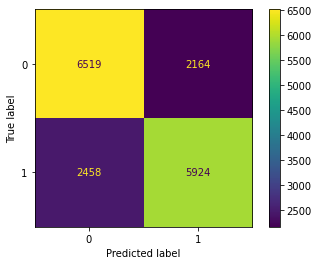

In [294]:
y_pred = classifier.predict(scaled_X_test)
y_pred = (y_pred > 0.5) * 1

print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

In [255]:
np.random.seed(42)

a = np.random.randint(1, 5, (10, 2))
a

array([[3, 4],
       [1, 3],
       [3, 4],
       [1, 1],
       [3, 2],
       [3, 3],
       [3, 3],
       [4, 1],
       [4, 4],
       [4, 3]])

In [257]:
a[2, [0, 1]]

array([3, 4])

In [228]:
b = np.arange(0, a.shape[0])
b

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [222]:
np.random.shuffle(b)
b

array([8, 2, 0, 6, 7, 9, 3, 1, 4, 5])

In [227]:
k = b[:4]
k[:3]

array([8, 2, 0])

In [172]:
c, a[b[c]]

(array([7, 1, 4, 0]),
 array([[4, 1],
        [1, 3],
        [3, 2],
        [3, 4]]))

In [175]:
b = np.delete(b, [0, 1, 2], axis = 0)
b

array([9])

In [239]:
k = k[2:]
k.__len__()

0

In [270]:
np.random.seed(42)

a = np.random.randint(0, 10, (10, 10))

array([[6, 3, 7, 4, 6, 9, 2, 6, 7, 4],
       [3, 7, 7, 2, 5, 4, 1, 7, 5, 1],
       [4, 0, 9, 5, 8, 0, 9, 2, 6, 3],
       [8, 2, 4, 2, 6, 4, 8, 6, 1, 3],
       [8, 1, 9, 8, 9, 4, 1, 3, 6, 7],
       [2, 0, 3, 1, 7, 3, 1, 5, 5, 9],
       [3, 5, 1, 9, 1, 9, 3, 7, 6, 8],
       [7, 4, 1, 4, 7, 9, 8, 8, 0, 8],
       [6, 8, 7, 0, 7, 7, 2, 0, 7, 2],
       [2, 0, 4, 9, 6, 9, 8, 6, 8, 7]])

In [279]:

a[[1,2,3]][:,[1,2,3]]

array([[7, 7, 2],
       [0, 9, 5],
       [2, 4, 2]])

In [283]:
a[[1, 2, 3],:[1, 2, 3]]

TypeError: slice indices must be integers or None or have an __index__ method